In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys 
import time
import pandas as pd
import random
import re

# 브라우저 열기
browser = webdriver.Chrome()

#채널 내 조회수가 높은 광고들 파악

#1. 잇섭
url = 'https://www.youtube.com/@ITSUB/videos'
browser.get(url)

for i in range(10):
    # 화면 빈 곳을 선택
    body = browser.find_elements('css selector', 'body')[0]
    # Page Down 버튼을 입력..
    body.send_keys(Keys.PAGE_DOWN)
    body.send_keys(Keys.PAGE_DOWN)
    body.send_keys(Keys.PAGE_DOWN)
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(random.uniform(2, 4))

html = browser.page_source 
soup = BeautifulSoup(html, 'html.parser')
video_list = soup.select('ytd-rich-grid-media.style-scope.ytd-rich-item-renderer')
filtered_video_list = []
results=[]

for video in video_list:
    title = video.select('#video-title')[0].text
    
    view = video.select('div#metadata-line > span')[0].text
    numbers = re.findall(r'\d+', view)
    view_number = int(numbers[0])
    
    original_date = video.select('div#metadata-line > span')[1].text
    date = original_date
    # '일 전', '개월 전', '년 전'에 따라 다르게 처리
    if '시간 전' in date:
        date = 1 
    elif '일 전' in date:
        date = int(date.replace('일 전', ''))
    elif '주 전' in date:
        date = int(date.replace('주 전', '')) * 3
    elif '개월 전' in date:
        date = int(date.replace('개월 전', '')) * 30
    elif '년 전' in date:
        date = int(date.replace('년 전', '')) * 365
    else:
        try:
            date = int(date)
        except ValueError:
            print(f"{date}를 숫자로 변환할 수 없습니다.")
            continue
    
    link = video.select('#video-title-link')[0]['href']
    full_link = 'https://www.youtube.com' + link
    
     # 날짜가 330 이하인 경우만 수집
    if date <= 330 and '아이폰 15' in title: 
#          print(title, '|', original_date, '|', view_number,'|',full_link)
        data = [title, original_date, view, full_link]
        results.append(data)

df = pd.DataFrame(results)
df.columns = ['title','original_date','view','full_link']

df_sorted = df.sort_values(by='view', ascending=True)
# df_sorted['title']

video_links = df_sorted['full_link'].tolist()
#print(video_links)


results2 = []
for link in video_links:
    browser.get(link)
    time.sleep(3)
    
    for i in range(10):
        body = browser.find_elements('css selector', 'body')[0]
        body.send_keys(Keys.PAGE_DOWN)
        body.send_keys(Keys.PAGE_DOWN)
        body.send_keys(Keys.PAGE_DOWN)
        body.send_keys(Keys.PAGE_DOWN)
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(2)
    
    html = browser.page_source 
    soup = BeautifulSoup(html, 'html.parser')
    replies = soup.select('ytd-comment-thread-renderer')
    title = soup.select('h1.style-scope.ytd-watch-metadata > yt-formatted-string')[0].text
#     print('[',title.']')
    
    for reply in replies:
        reply_content = reply.select('#content > yt-formatted-string')[0].text
        
        data = [title, reply_content]
        results2.append(data)
#         print(reply_content)
#         print('-'*60)
        
        next_link = df.loc[df['full_link'] == link, 'full_link'].shift(-1).values[0]

df = pd.DataFrame(results2, columns=['title','reply'])
df.to_csv('./아이폰15시리즈 유튜브 후기.csv', index=False)

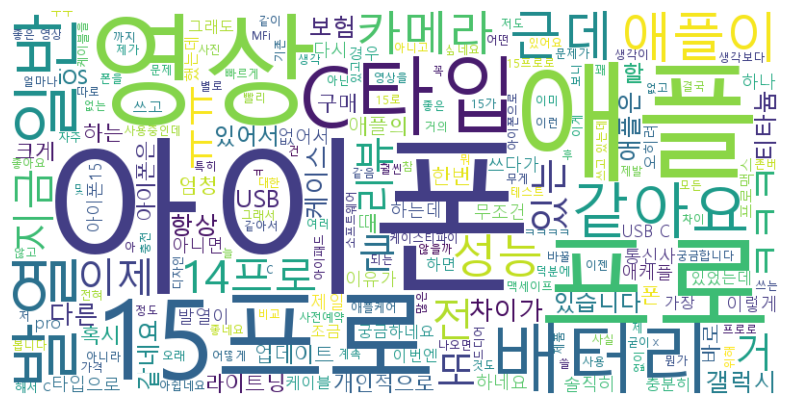

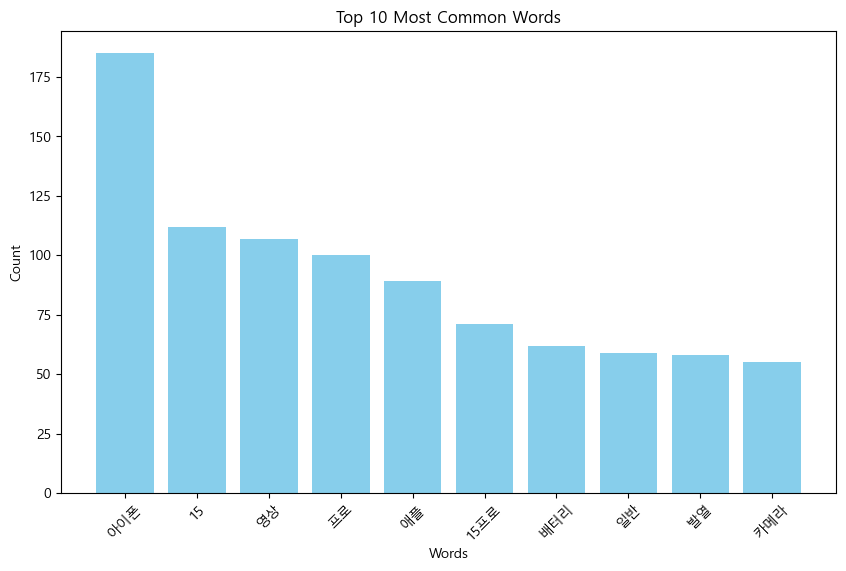

   word  count
0   아이폰    185
1    15    112
2    영상    107
3    프로    100
4    애플     89
5  15프로     71
6   배터리     62
7    일반     59
8    발열     58
9   카메라     55


In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import font_manager, rc

raw = pd.read_csv('./아이폰15시리즈 유튜브 후기.csv')
reviews = raw['reply'].dropna()
text = ' '.join(reviews)

# NLTK를 사용하여 토큰화
tokens = word_tokenize(text)

# 불용어리스트 지정
stop_words = set(['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
'은','을','의','이','인','임','자','잘','좀','지','하다','한','너무','많이','진짜','이번에',
'잇섭','님','잇섭님','때문에','더','확실히','하지만', '그리고','역시','상당히','같은데','감사합니다','그','하고','딱','안','아직','이게'
'것이','정말','보면','저는','물론','같습니다','것','합니다','ㅎㅎ','ㅋㅋ','보고','이번에', '.', ',', '?', '!', '(', ')','...','..'
,'이번','수','같은','그냥','같','있'])

# 불용어 제거
tokens = [word for word in tokens if word.lower() not in stop_words]

# '성능이'와 '성능'을 합쳐서 카운트 --> 비슷한 단어 하나로 하기
for i, word in enumerate(tokens):
    if word.lower() == '성능이':
        tokens[i] = '성능'

# 워드클라우드 생성 및 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 사용하고자 하는 한글 폰트의 경로를 지정
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(' '.join(tokens))

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 단어 빈도수 분석 및 한글 폰트 설정
word_counter = Counter(tokens)
most_common_words = word_counter.most_common(10)

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

df_word_count = pd.DataFrame(most_common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 6))
plt.bar(df_word_count['word'], df_word_count['count'], color='skyblue')
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print(df_word_count)